In [1]:
from scipy import stats
import numpy as np
import pandas as pd

In [2]:
islander_data = pd.read_csv('https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA_Analisis_de_datos/main/clase_2/datasets/Islander_data.csv')
islander_data.head(5)


In [ ]:
weather_data = pd.read_csv('weatherAUS.csv')

In [3]:
weather_data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21/06/2017,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,22/06/2017,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,23/06/2017,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,24/06/2017,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [4]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [35]:
weather_data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,145460.000000,135197.000000,145460.000000,145460.000000,143693.000000,...,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,145460.000000,145460.000000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,8.306565,40.035230,7.943826,8.002317,14.043426,...,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,0.264004,0.264066
std,6.398495,7.119049,8.478060,4.193704,3.785483,4.971722,13.607062,4.921740,4.739865,8.915375,...,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,0.489024,0.489138
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,0.000000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,4.000000,31.000000,3.000000,4.000000,7.000000,...,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,0.000000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,9.000000,39.000000,8.000000,8.000000,13.000000,...,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,0.000000,0.000000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,13.000000,48.000000,12.000000,12.000000,19.000000,...,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,0.000000,0.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,16.000000,135.000000,16.000000,16.000000,130.000000,...,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000,2.000000,2.000000


In [5]:
numerical_var_OLD =['age', 'Mem_Score_Before', 'Mem_Score_After']
category_var_OLD = ['Happy_Sad_group', 'Dosage', 'Drug']
target_var_OLD = ['Diff']

#
numerical_var = ['MinTemp',
                 'MaxTemp', 
                 'Rainfall', 
                 'Evaporation',
                 'Sunshine',
                 'WindGustSpeed',
                 'WindSpeed9am',
                 'WindSpeed3pm',
                 'Humidity9am',
                 'Humidity3pm',
                 'Pressure9am',	
                 'Pressure3pm',
                 'Cloud9am',
                 'Cloud3pm',
                 'Temp9am',
                 'Temp3pm']

category_var = ['WindGustDir',
                'WindDir9am',
                'WindDir3pm',
                'RainToday']

target_var = ['RainTomorrow']

In [38]:
# Convert 'Date' column to datetime
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%d/%m/%Y')

# Set 'Date' as the index
weather_data.set_index('Date', inplace=True)

# Interpolate missing values
weather_data['MinTemp'] = weather_data['MinTemp'].interpolate(method='time')
weather_data['MaxTemp'] = weather_data['MaxTemp'].interpolate(method='time')

# Create new features
weather_data['Year'] = weather_data.index.year
weather_data['Month'] = weather_data.index.month
weather_data['Day'] = weather_data.index.day
weather_data['DayOfWeek'] = weather_data.index.dayofweek

# Reset the index
weather_data.reset_index(inplace=True)

# Add new features to 'numerical_var'
numerical_var.extend(['Year', 'Month', 'Day', 'DayOfWeek'])

In [41]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    145460 non-null  int32         
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     145460 non-null  int32         
 10  WindDir3pm     145460 non-null  int32         
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

In [6]:
islander_data[numerical_var_OLD + target_var_OLD].mean()

age                 39.530303
Mem_Score_Before    57.967677
Mem_Score_After     60.922222
Diff                 2.954545
dtype: float64

In [7]:
weather_data[numerical_var].mean()

MinTemp            12.194034
MaxTemp            23.221348
Rainfall            2.360918
Evaporation         5.468232
Sunshine            7.611178
WindGustSpeed      40.035230
WindSpeed9am       14.043426
WindSpeed3pm       18.662657
Humidity9am        68.880831
Humidity3pm        51.539116
Pressure9am      1017.649940
Pressure3pm      1015.255889
Cloud9am            4.447461
Cloud3pm            4.509930
Temp9am            16.990631
Temp3pm            21.683390
dtype: float64

In [8]:
islander_data[numerical_var_OLD + target_var_OLD].std()

age                 12.023099
Mem_Score_Before    15.766007
Mem_Score_After     18.133851
Diff                10.754603
dtype: float64

In [9]:
weather_data[numerical_var].std()

MinTemp           6.398495
MaxTemp           7.119049
Rainfall          8.478060
Evaporation       4.193704
Sunshine          3.785483
WindGustSpeed    13.607062
WindSpeed9am      8.915375
WindSpeed3pm      8.809800
Humidity9am      19.029164
Humidity3pm      20.795902
Pressure9am       7.106530
Pressure3pm       7.037414
Cloud9am          2.887159
Cloud3pm          2.720357
Temp9am           6.488753
Temp3pm           6.936650
dtype: float64

In [10]:
cov_mat_OLD = islander_data[['Mem_Score_Before', 'Mem_Score_After']].cov()

cov_mat_OLD

,Mem_Score_Before,Mem_Score_After
Mem_Score_Before,248.566970,230.871027
Mem_Score_After,230.871027,328.836560


In [11]:
cov_mat = weather_data[numerical_var].cov()
cov_mat

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,40.940738,33.525454,5.625411,12.541087,1.725898,15.587504,9.960151,9.874645,-28.297842,0.808311,-20.282715,-20.543672,1.459840,0.377401,37.388121,31.360822
MaxTemp,33.525454,50.680856,-4.514935,17.432235,12.338284,6.621058,0.914543,3.155278,-67.962010,-74.822042,-16.434329,-20.932844,-5.894470,-5.341742,40.793542,48.320851
Rainfall,5.625411,-4.514935,71.877497,-1.784646,-7.650481,15.259043,6.578953,4.304781,36.186525,44.834725,-10.174017,-7.576328,5.322848,4.348779,0.615065,-4.652676
Evaporation,12.541087,17.432235,-1.784646,17.587154,5.061547,11.434176,6.944276,4.626754,-39.707740,-33.479563,-7.986312,-8.636964,-2.148159,-2.003341,14.998134,16.577264
Sunshine,1.725898,12.338284,-7.650481,5.061547,14.329881,-1.774575,0.181165,1.740712,-34.944505,-48.327853,1.120685,-0.522097,-7.157973,-7.050597,7.121406,12.609682
WindGustSpeed,15.587504,6.621058,15.259043,11.434176,-1.774575,185.152144,72.398294,81.038130,-56.148134,-7.468954,-43.934541,-39.224579,2.783675,4.014504,13.388658,3.120020
WindSpeed9am,9.960151,0.914543,6.578953,6.944276,0.181165,72.398294,79.483917,40.587723,-45.935925,-5.832309,-14.362381,-10.933409,0.643855,1.310285,7.427271,0.280961
WindSpeed3pm,9.874645,3.155278,4.304781,4.626754,1.740712,81.038130,40.587723,77.612576,-24.444073,3.014143,-18.318910,-15.638229,1.361790,0.611706,9.329801,1.698873
Humidity9am,-28.297842,-67.962010,36.186525,-39.707740,-34.944505,-56.148134,-45.935925,-24.444073,362.109100,263.955507,18.756370,24.883500,24.616572,18.310821,-58.168936,-65.685947
Humidity3pm,0.808311,-74.822042,44.834725,-33.479563,-48.327853,-7.468954,-5.832309,3.014143,263.955507,432.469526,-4.043760,7.548991,30.896146,29.539370,-29.695534,-80.403518


In [12]:
islander_data[numerical_var_OLD + target_var_OLD].corr()

,age,Mem_Score_Before,Mem_Score_After,Diff
age,1.000000,0.066010,0.051879,-0.009293
Mem_Score_Before,0.066010,1.000000,0.807528,-0.104366
Mem_Score_After,0.051879,0.807528,1.000000,0.502330
Diff,-0.009293,-0.104366,0.502330,1.000000


In [14]:
weather_data[numerical_var].corr()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,1.000000,0.736555,0.103938,0.466993,0.072586,0.177415,0.175064,0.175173,-0.232899,0.006089,-0.450970,-0.461292,0.078754,0.021605,0.901821,0.708906
MaxTemp,0.736555,1.000000,-0.074992,0.587932,0.470156,0.067615,0.014450,0.050300,-0.504110,-0.508855,-0.332061,-0.427167,-0.289370,-0.277921,0.887210,0.984503
Rainfall,0.103938,-0.074992,1.000000,-0.064351,-0.227549,0.133659,0.087338,0.057887,0.224405,0.255755,-0.168154,-0.126534,0.198528,0.172403,0.011192,-0.079657
Evaporation,0.466993,0.587932,-0.064351,1.000000,0.365602,0.203021,0.193084,0.129400,-0.504092,-0.390243,-0.270362,-0.293581,-0.183793,-0.182618,0.545115,0.572893
Sunshine,0.072586,0.470156,-0.227549,0.365602,1.000000,-0.034750,0.005499,0.053834,-0.490819,-0.629130,0.041970,-0.019719,-0.675323,-0.703930,0.291188,0.490501
WindGustSpeed,0.177415,0.067615,0.133659,0.203021,-0.034750,1.000000,0.605303,0.686307,-0.215070,-0.026327,-0.458744,-0.413749,0.071736,0.109168,0.150150,0.032748
WindSpeed9am,0.175064,0.014450,0.087338,0.193084,0.005499,0.605303,1.000000,0.519547,-0.270858,-0.031614,-0.228743,-0.175817,0.025112,0.054639,0.128545,0.004569
WindSpeed3pm,0.175173,0.050300,0.057887,0.129400,0.053834,0.686307,0.519547,1.000000,-0.145525,0.016432,-0.296351,-0.255439,0.053337,0.025396,0.163030,0.027778
Humidity9am,-0.232899,-0.504110,0.224405,-0.504092,-0.490819,-0.215070,-0.270858,-0.145525,1.000000,0.666949,0.139442,0.186858,0.452297,0.357326,-0.471354,-0.498399
Humidity3pm,0.006089,-0.508855,0.255755,-0.390243,-0.629130,-0.026327,-0.031614,0.016432,0.666949,1.000000,-0.027544,0.051997,0.517120,0.523120,-0.221019,-0.557841


In [15]:
islander_data[numerical_var_OLD + target_var_OLD].median()

age                 37.00
Mem_Score_Before    54.80
Mem_Score_After     56.75
Diff                 1.70
dtype: float64

In [17]:
weather_data[numerical_var].median()

MinTemp            12.0
MaxTemp            22.6
Rainfall            0.0
Evaporation         4.8
Sunshine            8.4
WindGustSpeed      39.0
WindSpeed9am       13.0
WindSpeed3pm       19.0
Humidity9am        70.0
Humidity3pm        52.0
Pressure9am      1017.6
Pressure3pm      1015.2
Cloud9am            5.0
Cloud3pm            5.0
Temp9am            16.7
Temp3pm            21.1
dtype: float64

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

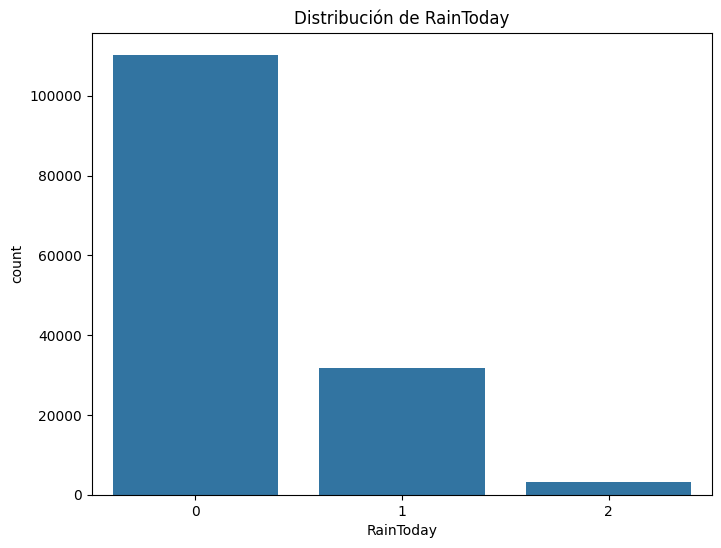

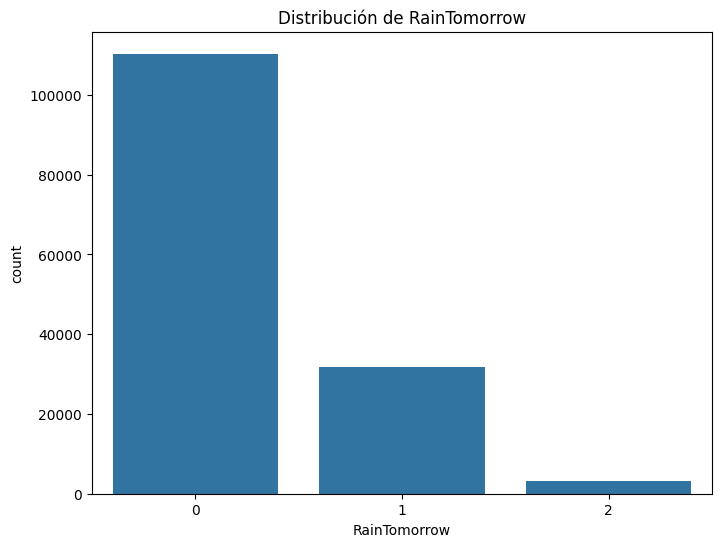

In [34]:
plt.figure(figsize=(8, 6))
sns.countplot(x='RainToday', data=weather_data)
plt.title('Distribución de RainToday')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='RainTomorrow', data=weather_data)
plt.title('Distribución de RainTomorrow')
plt.show()

In [29]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [30]:
weather_data.head(30)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,06/12/2008,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,07/12/2008,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,08/12/2008,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,09/12/2008,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,10/12/2008,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


In [31]:
le = LabelEncoder()

weather_data['WindGustDir'] = le.fit_transform(weather_data['WindGustDir'])
weather_data['WindDir9am'] = le.fit_transform(weather_data['WindDir9am'])
weather_data['WindDir3pm'] = le.fit_transform(weather_data['WindDir3pm'])
# df['Location'] = le.fit_transform(df['Location'])
weather_data['RainToday'] = le.fit_transform(weather_data['RainToday'])
weather_data['RainTomorrow'] = le.fit_transform(weather_data['RainTomorrow'])

In [32]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    145460 non-null  int32  
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     145460 non-null  int32  
 10  WindDir3pm     145460 non-null  int32  
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [33]:
weather_data.head(30)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,13,44.0,13,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0,0
1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,14,44.0,6,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0,0
2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,15,46.0,13,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0,0
3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,4,24.0,9,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0,0
4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,13,41.0,1,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
5,06/12/2008,Albury,14.6,29.7,0.2,NaN,NaN,14,56.0,13,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,0,0
6,07/12/2008,Albury,14.3,25.0,0.0,NaN,NaN,13,50.0,12,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,0,0
7,08/12/2008,Albury,7.7,26.7,0.0,NaN,NaN,13,35.0,10,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,0,0
8,09/12/2008,Albury,9.7,31.9,0.0,NaN,NaN,6,80.0,9,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,0,1
9,10/12/2008,Albury,13.1,30.1,1.4,NaN,NaN,13,28.0,8,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,1,0


ConversionError: Failed to convert value(s) to axis units: array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

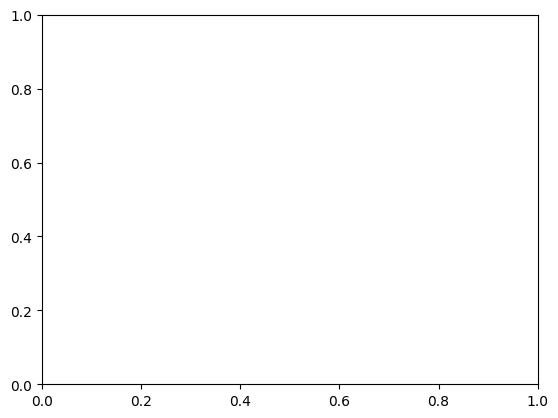

In [27]:
plt.hist(weather_data[['MinTemp', 'MaxTemp', 'RainToday']], bins=20)
plt.show()

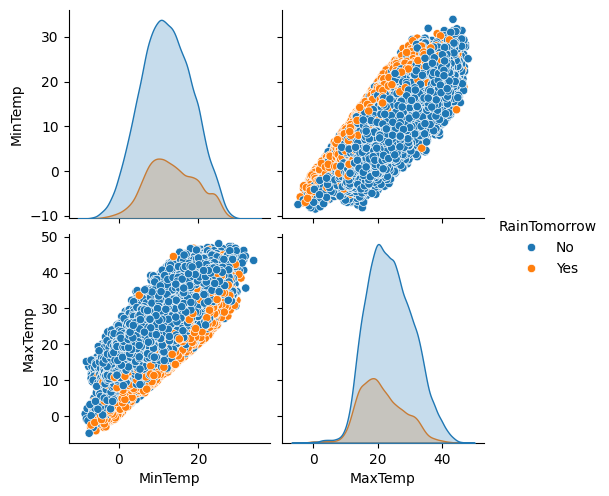

In [22]:
sns.pairplot(weather_data[['MinTemp', 'MaxTemp', 'RainTomorrow']], hue='RainTomorrow')

In [27]:
weather_data[numerical_var + target_var].median()

TypeError: Cannot convert [['No' 'No' 'No' ... 'No' 'No' nan]] to numeric

In [22]:
islander_data.describe()

,age,Dosage,Mem_Score_Before,Mem_Score_After,Diff
count,198.000000,198.000000,198.000000,198.000000,198.000000
mean,39.530303,1.989899,57.967677,60.922222,2.954545
std,12.023099,0.818504,15.766007,18.133851,10.754603
min,24.000000,1.000000,27.200000,27.100000,-40.400000
25%,30.000000,1.000000,46.525000,47.175000,-3.175000
50%,37.000000,2.000000,54.800000,56.750000,1.700000
75%,48.000000,3.000000,68.400000,73.250000,5.925000
max,83.000000,3.000000,110.000000,120.000000,49.000000


In [23]:
islander_data.mode()

,first_name,last_name,age,Happy_Sad_group,Dosage,Drug,Mem_Score_Before,Mem_Score_After,Diff
0,Jun,Durand,37.0,H,1.0,A,90.0,90.0,-1.3
1,NaN,NaN,NaN,S,NaN,NaN,NaN,96.0,0.0


In [25]:
islander_data[numerical_var + target_var].mode()

,age,Mem_Score_Before,Mem_Score_After,Diff
0,37.0,90.0,90.0,-1.3
1,NaN,NaN,96.0,0.0


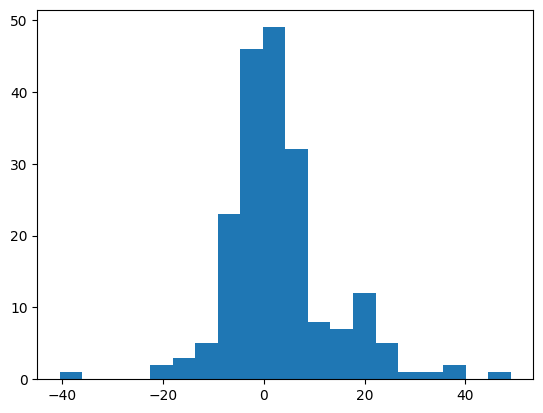

In [32]:
#plot diff
import matplotlib.pyplot as plt
plt.hist(islander_data['Diff'], bins=20)
plt.show()

#print how many values of Diff equal to 0 and -1.3



In [30]:
islander_data.Diff.value_counts()

Diff
 0.0     4
-1.3     4
-0.9     3
 5.2     3
 2.2     3
        ..
 19.4    1
 19.8    1
 13.7    1
 15.7    1
-1.0     1
Name: count, Length: 142, dtype: int64

In [34]:
zero_count = (islander_data['Diff'] == 0).sum()
negative_one_point_three_count = (islander_data['Diff'] == -1.3).sum()

print(f"Count of 0: {zero_count}")
print(f"Count of -1.3: {negative_one_point_three_count}")

Count of 0: 4
Count of -1.3: 4


In [35]:
islander_data[numerical_var + target_var].skew()

age                 1.069270
Mem_Score_Before    0.646570
Mem_Score_After     0.756992
Diff                0.766206
dtype: float64

In [38]:
islander_data[numerical_var + target_var].kurt()

age                 0.888832
Mem_Score_Before   -0.026350
Mem_Score_After     0.180319
Diff                3.379966
dtype: float64

In [39]:
import seaborn as sns

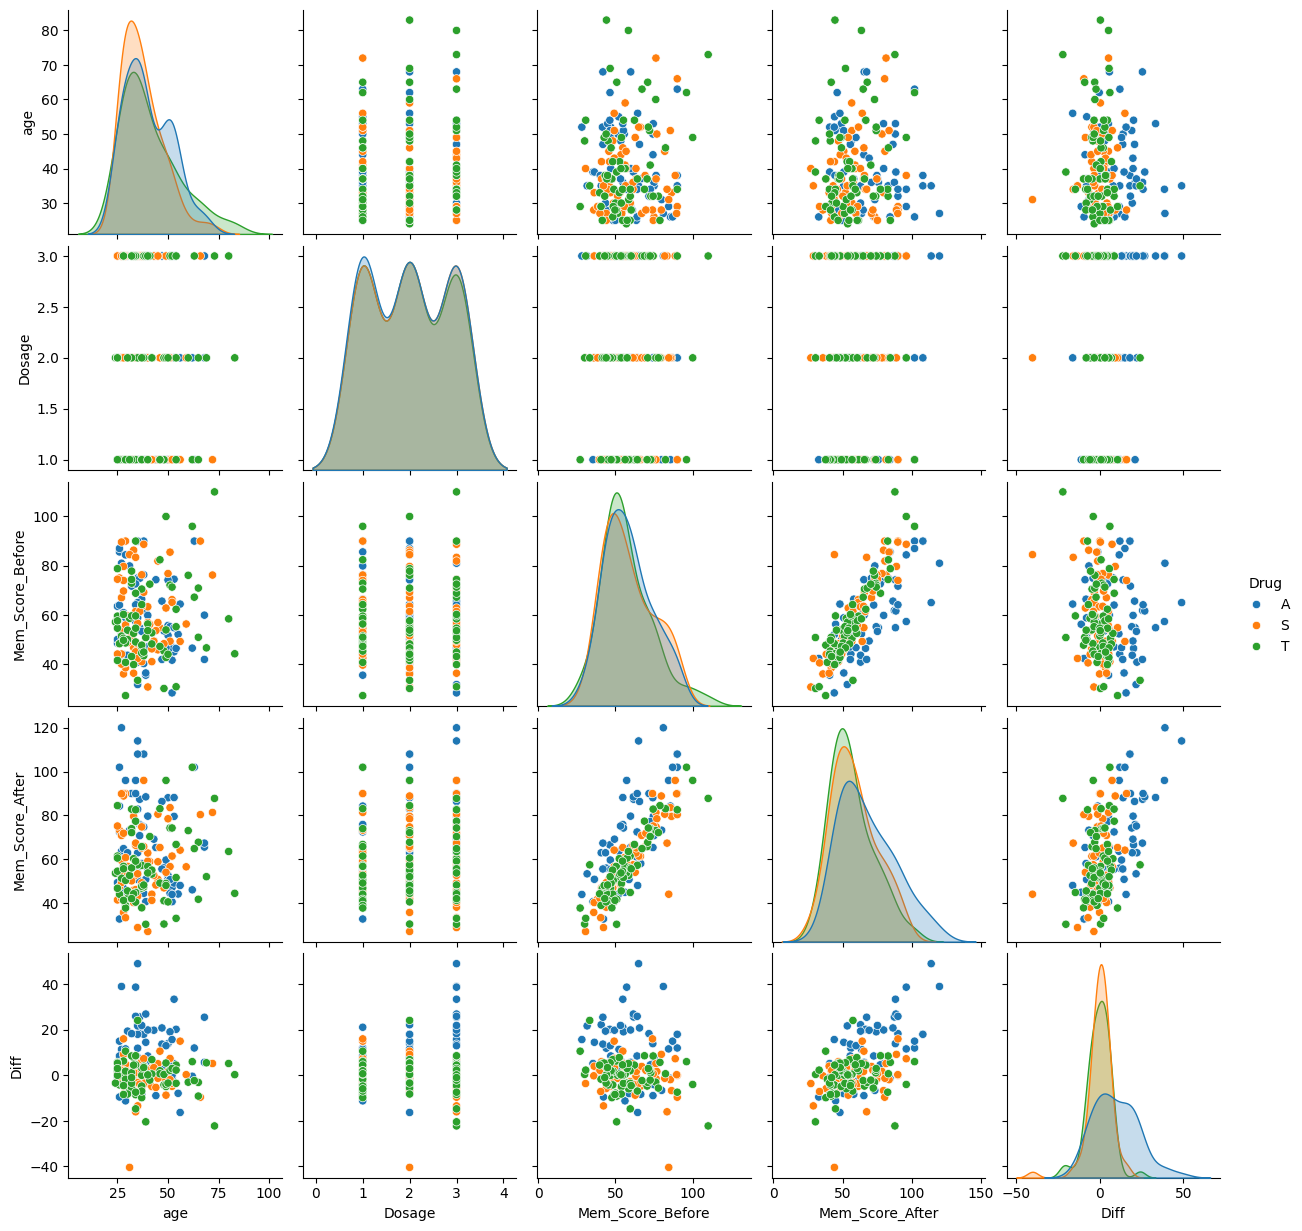

In [43]:
sns.pairplot(islander_data, hue='Drug')

<Axes: ylabel='Diff'>

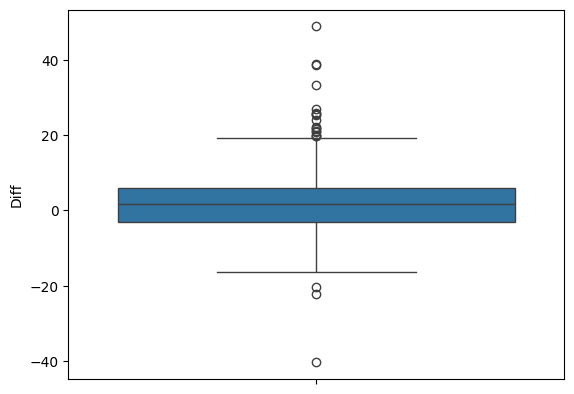

In [41]:
sns.boxplot(data = islander_data, y = 'Diff')

<Axes: ylabel='Mem_Score_Before'>

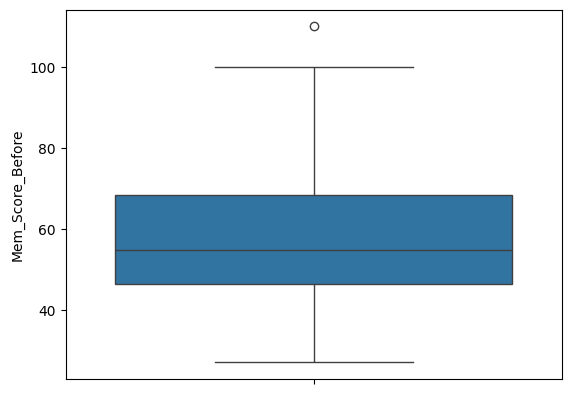

In [44]:
sns.boxplot(islander_data.Mem_Score_Before)

<Axes: ylabel='Mem_Score_After'>

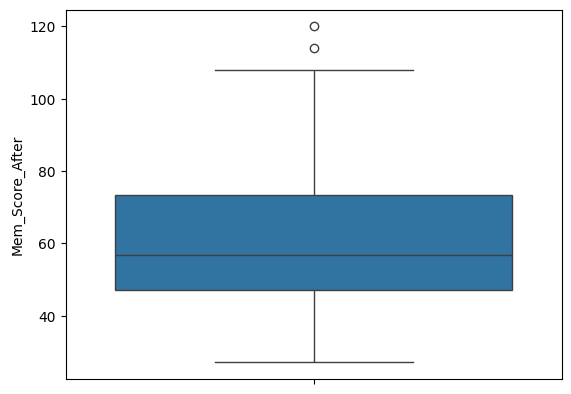

In [45]:
sns.boxplot(islander_data.Mem_Score_After)

<Axes: xlabel='Drug', ylabel='Diff'>

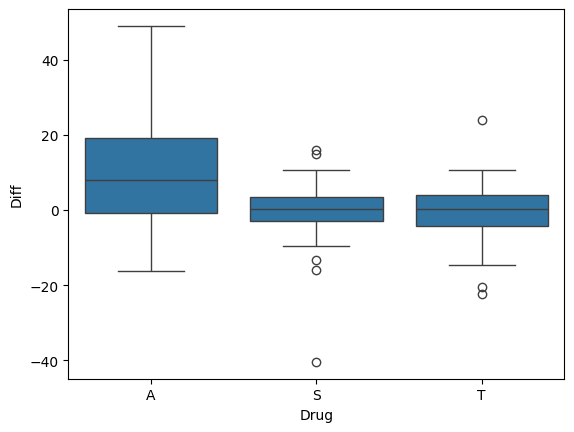

In [46]:
sns.boxplot(x=islander_data['Drug'], y=islander_data['Diff'])

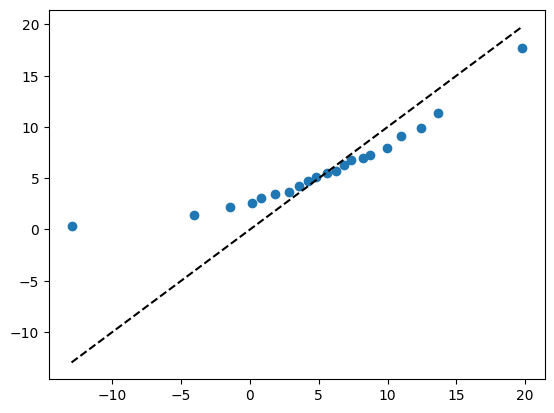

In [48]:
import numpy as np
import matplotlib.pyplot as plt

X = np.random.normal(5,5,250)
Y = np.random.rayleigh(5,250)

percs = np.linspace(0,100,21)
qn_a = np.percentile(X, percs)
qn_b = np.percentile(Y, percs)

plt.plot(qn_a,qn_b, ls="", marker="o")

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
plt.plot(x,x, color="k", ls="--")

plt.show()

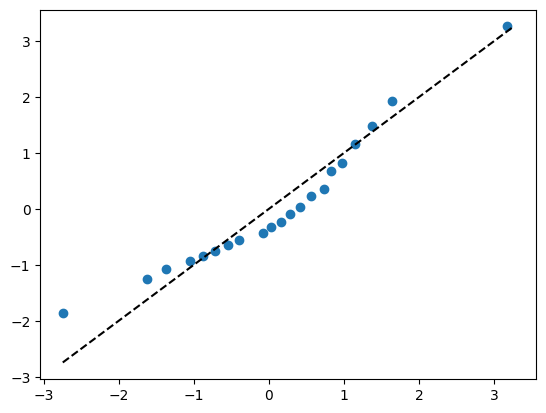

In [47]:

X = np.random.normal(0,1,len(islander_data))
Y = (islander_data.Mem_Score_After - islander_data.Mem_Score_After.mean()) / islander_data.Mem_Score_After.std()

percs = np.linspace(0,100,21)
qn_a = np.percentile(X, percs)
qn_b = np.percentile(Y, percs)

plt.plot(qn_a,qn_b, ls="", marker="o")

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
plt.plot(x,x, color="k", ls="--")

plt.show()